In [161]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import xarray as xr

from dynmodes import dynmodes
from calcN2_bray_adsrt import calcN2_bray_adsrt

import os
import gsw
import seawater as sw

In [2]:
%matplotlib inline
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

## Calculate vertical mode decomposition: Replicate what I did using Matlab starting with costant stratifcation

Text(0.5, 0, 'Normalised amplitude')

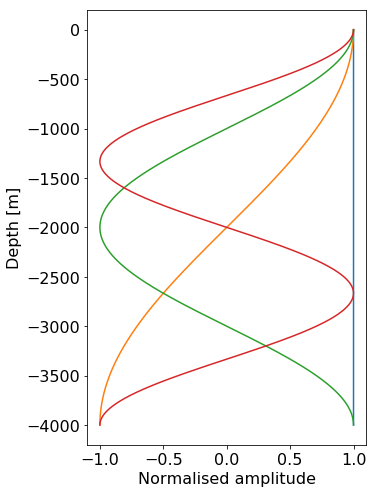

In [3]:
k = np.arange(0,4,1)
z = np.arange(-4000,1,1)
g = 9.81
N = 2e-3

fig = plt.figure(figsize=[5, 8])
ax = fig.subplots()

ck = np.zeros(len(k))

for ii in k:
    
    if k[ii] == 0:
        
        ck[ii] = np.sqrt(g * abs(min(z)))
        
        
    else: 
        
        ck[ii] = (N * abs(min(z))) / (k[ii] * np.pi)
        
    psi_k = np.cos((k[ii] * np.pi * z) / abs(min(z)))
    
    ax.plot(psi_k, z)

ax.set_ylabel('Depth [m]')
ax.set_xlabel('Normalised amplitude')

## Load the A05 data, compute CT and SA, average and plot

In [155]:
dat_dir = '/Users/dge105/Dropbox/MerMEED/data/CCHDO/A05/'
lon_lim = [-70, -65]

presi = np.arange(0, 5000, 2)

all_SA = np.zeros(np.shape(presi))
all_CT = np.zeros(np.shape(presi))

all_sp = np.zeros(np.shape(presi))
all_t = np.zeros(np.shape(presi))

for (dirpath, dirnames, filenames) in os.walk(dat_dir):
    
    for dd in dirnames:
        
        cr_path = dat_dir + dd

        for (cr_dirpath, cr_dirnames, cr_filenames) in os.walk(cr_path):
            for cc in cr_filenames:
                
                ctd_file = cr_path + '/' + cc
                dset = xr.open_dataset(ctd_file)
                
                if (dset.longitude >= lon_lim[0]) & (dset.longitude <= lon_lim[1]):  
                    
                    SA = gsw.SA_from_SP(dset.salinity.data, dset.pressure.data,
                                        dset.longitude.data, dset.latitude.data)
                    CT = gsw.CT_from_t(SA, dset.temperature.data, dset.pressure.data)
            
                    if np.all(np.diff(dset.pressure.data) > 0):
                        # print('x isn''t increasing ' + cc)
                        # ax4.plot(dset.pressure.data) 
                        
                        SAi = np.interp(presi, dset.pressure.data, SA)
                        SAi[presi > np.nanmax(dset.pressure.data)] = np.nan
            
                        CTi = np.interp(presi, dset.pressure.data, CT)
                        CTi[presi > np.nanmax(dset.pressure.data)] = np.nan

                        all_SA = np.column_stack((all_SA, SAi))
                        all_CT = np.column_stack((all_CT, CTi))       
                        
                        spi = np.interp(presi, dset.pressure.data, dset.salinity.data)
                        spi[presi > np.nanmax(dset.pressure.data)] = np.nan
            
                        ti = np.interp(presi, dset.pressure.data, dset.temperature.data)
                        ti[presi > np.nanmax(dset.pressure.data)] = np.nan

                        all_sp = np.column_stack((all_sp, spi))
                        all_t = np.column_stack((all_t, ti)) 

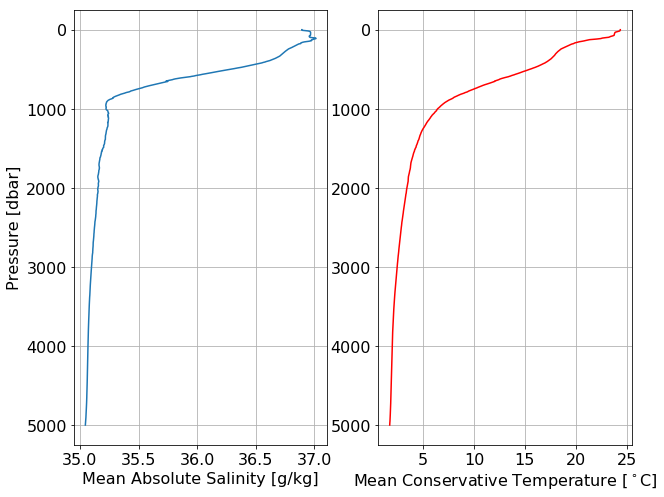

In [152]:
all_CT = np.delete(all_CT, 0, 1)
all_SA = np.delete(all_SA, 0, 1)
all_t = np.delete(all_t, 0, 1)
all_sp = np.delete(all_sp, 0, 1)

fig2 = plt.figure(figsize=[10,8])
ax1, ax2 = fig2.subplots(nrows=1, ncols=2)

ax1.plot(np.nanmean(all_SA, axis=1), presi)
ax1.invert_yaxis()
ax1.set_ylabel('Pressure [dbar]')
ax1.set_xlabel('Mean Absolute Salinity [g/kg]')
ax1.grid(True)

ax2.plot(np.nanmean(all_CT, axis=1), presi, 'r')
ax2.invert_yaxis()
ax2.set_xlabel('Mean Conservative Temperature [$^\circ$C]')
ax2.grid(True)
# ax2.yaxis.set_major_formatter(plt.NullFormatter())

## Load the CTD data and compute the adiabatically sorted N<sup>2</sup>, average and plot

In [157]:
dat_dir = '/Users/dge105/Dropbox/MerMEED/data/CCHDO/A05/'
lon_lim = [-70, -65]

presi = np.arange(0, 5000, 2)

all_N2 = np.zeros(np.shape(presi))

for (dirpath, dirnames, filenames) in os.walk(dat_dir):
    
    for dd in dirnames:
        
        cr_path = dat_dir + dd

        for (cr_dirpath, cr_dirnames, cr_filenames) in os.walk(cr_path):
            for cc in cr_filenames:
                
                ctd_file = cr_path + '/' + cc
                dset = xr.open_dataset(ctd_file)
                
                if (dset.longitude >= lon_lim[0]) & (dset.longitude <= lon_lim[1]):  
                    
                    SA = gsw.SA_from_SP(dset.salinity.data, dset.pressure.data,
                                        dset.longitude.data, dset.latitude.data)
                    CT = gsw.CT_from_t(SA, dset.temperature.data, dset.pressure.data)
            
                    if np.all(np.diff(dset.pressure.data) > 0):
                        # print('x isn''t increasing ' + cc)
                        # ax4.plot(dset.pressure.data) 
                        
                        plev = 100
                        N2_bray = calcN2_bray_adsrt(dset.salinity.data, dset.temperature.data,
                                                   dset.pressure.data, dset.latitude.data, plev)
                        
                        N2_brayi = np.interp(presi, dset.pressure.data, N2_bray)
                        N2_brayi[presi > np.nanmax(dset.pressure.data)] = np.nan

                        all_N2 = np.column_stack((all_N2, N2_brayi))


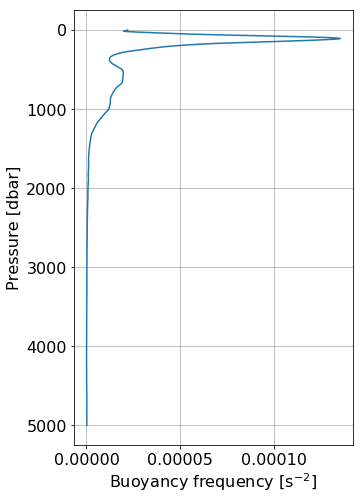

In [174]:
all_N2 = np.delete(all_N2, 0, 1)

figN2 = plt.figure(figsize=[5,8])
axN2 = figN2.subplots()

axN2.plot(np.nanmean(all_N2, axis=1), presi)
axN2.invert_yaxis()
axN2.set_ylabel('Pressure [dbar]')
axN2.set_xlabel('Buoyancy frequency [s$^{-2}$]')
axN2.grid(True)


## Compute the vertical modes using the function dynmodes.py

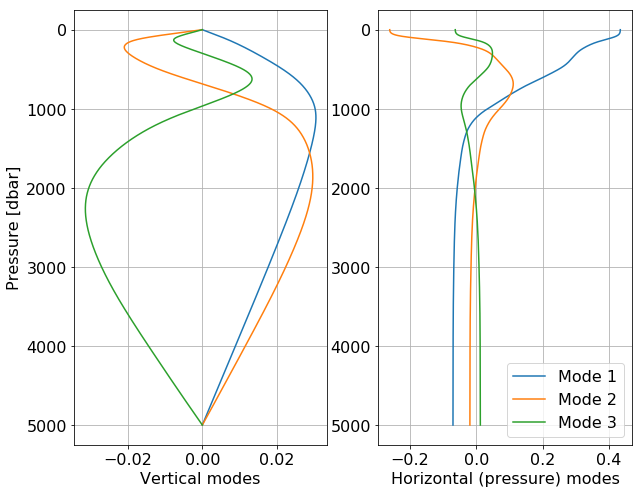

In [184]:
depth = -sw.dpth(presi, 26)
[wmodes,pmodes,ce] = dynmodes(np.nanmean(all_N2, axis=1), depth, 3)
# test = np.nanmean(all_N2, axis=1).T

fig_modes = plt.figure(figsize=[10, 8])

ax_vm, ax_pm = fig_modes.subplots(1, 2)

for ii in range(0,3):
    ax_vm.plot(wmodes[ii,:], presi)
    ax_pm.plot(pmodes[ii,:], presi)

ax_vm.invert_yaxis()
ax_pm.invert_yaxis()

ax_vm.set_ylabel('Pressure [dbar]')
ax_vm.set_xlabel('Vertical modes')
ax_vm.grid(True)

# ax_pm.set_ylabel('Pressure [dbar]')
ax_pm.set_xlabel('Horizontal (pressure) modes')
ax_pm.grid(True)

ax_pm.legend(('Mode 1', 'Mode 2', 'Mode 3'),loc='lower right')

### Test area...Just checking that everything works as expected 

Text(0.5, 0, 'Conservative Temperature [$^\\circ$C]')

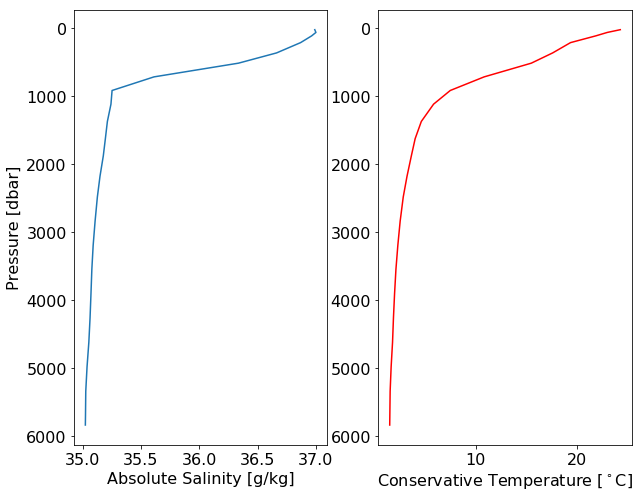

In [58]:
presi = np.arange(0, 5000, 2)

ctd_file = '/Users/dge105/Dropbox/MerMEED/data/CCHDO/A05/4_74DI20040404_nc_hyd/74DI20040404_00048_00001_hy1.nc'

dset = xr.open_dataset(ctd_file)

SA = gsw.SA_from_SP(dset.salinity.data, dset.pressure.data, dset.longitude.data, dset.latitude.data)
CT = gsw.CT_from_t(SA, dset.temperature.data, dset.pressure.data)

np.all(np.diff(dset.pressure.data) > 0)
SAi = np.interp(presi, dset.pressure.data, SA)
SAi[presi > np.nanmax(dset.pressure.data)] = np.nan

CTi = np.interp(presi, dset.pressure.data, CT)
CTi[presi > np.nanmax(dset.pressure.data)] = np.nan

fig = plt.figure(figsize=[10, 8])
ax1, ax2 = fig.subplots(nrows=1, ncols=2)

ax1.plot(SA, dset.pressure.data)
ax1.invert_yaxis()
ax1.set_ylabel('Pressure [dbar]')
ax1.set_xlabel('Absolute Salinity [g/kg]')

ax2.plot(CT, dset.pressure.data,'r')
ax2.invert_yaxis()
ax2.set_xlabel('Conservative Temperature [$^\circ$C]')
#print(dset)